# Beyond Local Sensitivity Analysis: The Fokker-Planck Equation

It is possible to derive an equation that describes the evolution of the probability density function (PDF) of a dynamical system when the initial conditions are uncertain. This equation is called the Fokker-Planck equation.
Keep in mind, that the equation we derive is not the most general form of the Fokker-Planck equation.
To do that, we would need the theory of stochastic differential equations.

Suppose that we have a dynamical system that is described by the following ordinary differential equation (ODE):

$$
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},t)
$$

where $\mathbf{x}$ is a vector of state variables and $\mathbf{f}$ is a vector of functions that describe the evolution of the state variables.
The initial conditions of the system are uncertain:

$$
\mathbf{x}_0 \sim p_0(\mathbf{x}_0).
$$

So, we can think of the solution of the initial value problem as a random variable $X_t$. The probability density function of $X_t$ is denoted by $p(\mathbf{x},t)$.
We want to derive an equation that describes the evolution of $p(\mathbf{x},t)$.

Consider a small volume $V$ in the state space of the system. The probability that the state of the system is in this volume is

$$
\int_V p(\mathbf{x},t) \, d\mathbf{x}.
$$

The rate of change of this probability is given by the flux of the probability out of the volume $V$:

$$
\frac{\partial}{\partial t} \int_V p(\mathbf{x},t) \, d\mathbf{x} = - \int_{\partial V} \mathbf{f}(\mathbf{x},t) \cdot \mathbf{n} \, p(\mathbf{x},t) \, dS
$$

where $\mathbf{n}$ is the outward pointing normal vector of the surface $\partial V$ of the volume $V$ and $dS$ is the surface element of $\partial V$.
Using the divergence theorem, we can rewrite this equation as

$$
\frac{\partial}{\partial t} \int_V p(\mathbf{x},t) \, d\mathbf{x} = - \int_V \nabla \cdot \left[ \mathbf{f}(\mathbf{x},t) \, p(\mathbf{x},t) \right] \, d\mathbf{x}.
$$

Since the volume $V$ is arbitrary, we can conclude that

$$
\frac{\partial}{\partial t} p(\mathbf{x},t) = - \nabla \cdot \left[ \mathbf{f}(\mathbf{x},t) \, p(\mathbf{x},t) \right].
$$

The function $p(\mathbf{x},t)$ must also satisfy the initial condition

$$
p(\mathbf{x},0) = p_0(\mathbf{x}).
$$

This is the Fokker-Planck equation (for the case of a deterministic dynamical system with random initial conditions).
We can solve this equation with standard numerical methods for partial differential equations.
But, it is an impossible task to solve this equation for a high-dimensional system.

## Example: Exponential Decay

Consider the one-dimensional dynamical system:

$$
\dot{x} = - \lambda x
$$

where $\lambda$ is a constant.
The initial condition is:

$$
x_0 \sim \mathcal{N}(\mu_0,\sigma_0^2)
$$

where $\mathcal{N}(\mu_0,\sigma_0^2)$ denotes the normal distribution with mean $\mu_0$ and variance $\sigma_0^2$.

The Fokker-Planck equation for this system is:

$$
\frac{\partial}{\partial t} p(x,t) = \lambda \frac{\partial}{\partial x} \left[ x \, p(x,t) \right].
$$

We can solve this equation analytically.
The solution is:

$$
p(x,t) = \frac{1}{\sqrt{2 \pi \sigma_t^2}} \exp \left( - \frac{(x-\mu_t)^2}{2 \sigma_t^2} \right)
$$

where

$$
\mu_t = \mu_0 \exp(-\lambda t)
$$

and

$$
\sigma_t^2 = \sigma_0^2 \exp(-2 \lambda t) + \frac{\mu_0^2}{2 \lambda} \left( 1 - \exp(-2 \lambda t) \right).
$$

Let's demonstrate this numerically as well.

In [26]:
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Solution of the initial value problem:
@jit
@partial(vmap, in_axes=(None, 0, None))
def exp_sol(t, x0, decay_rate):
    return x0 * jnp.exp(-decay_rate * t)

# Exact solution of the the Fokker-Planck equation:
@jit
@partial(vmap, in_axes=(0, 0, None, None, None))
def fp_sol(t, x0, decay_rate, mu0, sigma0):
    mu_t = mu0 * jnp.exp(-decay_rate * t)
    sigma2_t = sigma0**2 * jnp.exp(-2 * decay_rate * t) \
        + mu0**2 / (2 * decay_rate) * (1 - jnp.exp(-2 * decay_rate * t))
    return 1. / jnp.sqrt(2 * jnp.pi * sigma2_t) \
        * jnp.exp(-(x0 - mu_t)**2 / (2 * sigma2_t))


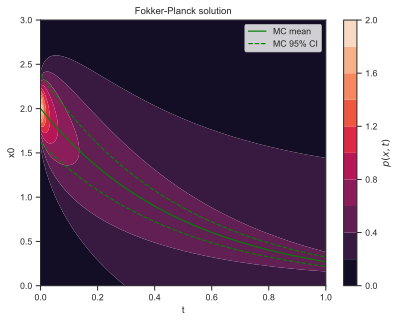

In [33]:
# Do Monte Carlo to estimate the solution of the Fokker-Planck equation:
mu0 = 2.0
sigma0 = 0.2
decay_rate = 2
ts = np.linspace(0, 1, 100)
mc_x0s = np.random.normal(mu0, sigma0, 10_000)
mc_res = exp_sol(ts, mc_x0s, decay_rate)

x0s = np.linspace(0, 3, 100)
T, X0 = np.meshgrid(ts, x0s)
t_flat = T.flatten()
x0_flat = X0.flatten()
fp_res = fp_sol(t_flat, x0_flat, decay_rate, mu0, sigma0)
FP = fp_res.reshape(T.shape)

fig, ax = plt.subplots()
p = ax.contourf(T, X0, FP, levels=10)
plt.colorbar(p, ax=ax, label="$p(x,t)$")
ax.plot(ts, mc_res.mean(axis=0), color='g', label='MC mean')
ax.plot(ts, np.percentile(mc_res, 2.5, axis=0), color='g', linestyle='--', label='MC 95% CI')
ax.plot(ts, np.percentile(mc_res, 97.5, axis=0), color='g', linestyle='--')
ax.set(xlabel='t', ylabel='x0', title='Fokker-Planck solution')
ax.legend()

This is pretty much the most complicated example that we can solve analytically.
For more complicated systems, we have to use numerical methods.
But remember **we do not usually try to solve the Fokker-Planck equation**.
It doesn't scale well to high-dimensional systems.
There are are other methods that are more efficient.
But, the Fokker-Planck equation can help us make some analytical progress and also has some applications in the theory of continuous normalizing flows.
It's good to know about its existence because it appears in the literature from time to time.